# Purpose:
- Analyze hydration-driven z-drift divergence in cre lines other than GAD2-Cre
- From VisualBehaviorMultiscope, 2x4 configuration


In [3]:
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
from matplotlib import pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
from pymongo import MongoClient
from visual_behavior import database as db
from datetime import datetime
import seaborn as sns

mongo = MongoClient('flaskapp.corp.alleninstitute.org', 27017)

save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')

def get_depth_region_from_db(oeid):
    query = '''
    SELECT oe.id, st.acronym, oe.calculated_depth, imd.depth
    FROM ophys_experiments oe
    JOIN structures st ON st.id = oe.targeted_structure_id
    JOIN imaging_depths imd ON imd.id = oe.imaging_depth_id
    WHERE oe.id = {}
    '''.format(oeid)
    lims_results = db.lims_query(query)
    return lims_results.depth.values[0], lims_results.acronym.values[0]


def get_zdrift_results(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
        
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids

def get_zdrift_results_first_last(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}_first_last.h5'
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids


# Select dataset

In [45]:
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table(passed_only=False)
vbms_table = exp_table.query('project_code == "VisualBehaviorMultiscope"')
session_ids = vbms_table.groupby('ophys_session_id').size()
session_ids = session_ids[session_ids == 8].index
table = vbms_table.query('ophys_session_id in @session_ids')
print(len(table))

2080


In [12]:
table.groupby('session_type').size()

session_type
OPHYS_0_images_A_habituation         8
OPHYS_1_images_A                   328
OPHYS_2_images_A_passive           304
OPHYS_2_images_B_passive             8
OPHYS_3_images_A                   336
OPHYS_4_images_B                   352
OPHYS_5_images_A_passive             8
OPHYS_5_images_B_passive           232
OPHYS_6_images_A                     8
OPHYS_6_images_B                   272
OPHYS_7_receptive_field_mapping    216
SNR_9                                8
dtype: int64

In [13]:
table = table[table.session_type.str.contains('OPHYS_') & ~table.session_type.str.contains('OPHYS_0')]

In [14]:
table.groupby('full_genotype').apply(lambda x: len(x.mouse_id.unique()))

full_genotype
Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt    11
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                9
Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt               11
dtype: int64

In [42]:
# prepare dataframe to be passed to multi_plane_drift_sbatch.py
table = table[['mouse_id','ophys_session_id', 'full_genotype', 'session_type']].drop_duplicates()
for osid in table.ophys_session_id.values:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    if 'change_detection' not in session:
        if table.query('ophys_session_id == @osid').session_type.str.contains('OPHYS_7').values[0]:
            water = 0
        elif table.query('ophys_session_id == @osid').session_type.str.contains('passive').values[0]:
            water = 0
        else:
            raise ValueError(f'no change detection data for {osid}')
    else:
        water = session['change_detection']['total_reward_volume']
    table.loc[table.ophys_session_id == osid, 'water'] = water
    

In [44]:
table.to_csv(save_dir / 'multi_plane_zdrift_vb_multiscope.csv', index=False)

In [5]:
load_csv = save_dir / 'multi_plane_zdrift_vb_multiscope.csv'
table = pd.read_csv(load_csv)
len(table)

258

# Some sessions errored out
- 23 / 258 sessions errored out
- Just use the remaining 235 sessions

In [2]:
job_records_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\job_records')

# filter by created time, if needed
time_since = datetime(2024, 3, 26, 15, 0, 0)
# from job_dir get files created after time_since
files = [f for f in job_records_dir.glob('**/*') if f.is_file() and f.stat().st_ctime > time_since.timestamp()]

failed_files = []
failed_osids = []
success_word = 'total time ='
for file in files:
    with open(file, 'r') as f:
        lines = f.readlines()
        if np.array([success_word in l for l in lines]).any():
            pass
        else:
            failed_files.append(file)
            failed_osids.append(int(file.name.split('_')[-1].split('.')[0]))
failed_osids = np.unique(failed_osids)

In [3]:
failed_osids

array([ 841778484,  842023261,  842364341,  843871999,  844469521,
        852070825,  856201876,  870762788,  871906231,  873247524,
        873720614,  874616920,  875259383,  917886781,  918180797,
        924644503,  927620400,  942628468,  974167263,  976061108,
       1001385706, 1047935100, 1050231786])

In [4]:
load_csv = save_dir / 'multi_plane_zdrift_vb_multiscope.csv'
table = pd.read_csv(load_csv)
table = table[~table.ophys_session_id.isin(failed_osids)]
len(table)

235

In [7]:
table.head()

,mouse_id,ophys_session_id,full_genotype,session_type,water
0,457841,952430817,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_2_images_A_passive,0.000
1,457841,954954402,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_3_images_A,0.396
2,457841,960475921,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_7_receptive_field_mapping,0.000
3,457841,957020350,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_4_images_B,0.515
4,457841,955775716,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_3_images_A,0.445


In [6]:
succeeded_osids = np.setdiff1d(table.ophys_session_id.values, failed_osids)
len(succeeded_osids)

235

In [11]:
not_processed_opids = []
not_processed_osids = []
for osid in succeeded_osids:
    opids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    for opid in opids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(opid)
        except:
            ocid = 'none'
        zdrift_opid_dir = zdrift_dir / f'container_{ocid}' / f'experiment_{opid}'
        zdrift_first_last_fn = zdrift_opid_dir / f'{opid}_zdrift_ref_{opid}_first_last.h5'
        if not zdrift_first_last_fn.exists():
            not_processed_opids.append(opid)
            not_processed_osids.append(osid)
    

In [12]:
np.unique(not_processed_osids)

array([], dtype=float64)

In [13]:
not_processed_opids

[]

### All 235 osids were run correctly

## example time-series plot
- One example per cre line, divided into VISp and VISl, with or without water

In [10]:
# Load tables
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table(passed_only=False)
vbms_table = exp_table.query('project_code == "VisualBehaviorMultiscope"')

zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
load_fn = zdrift_dir / 'multi_plane_zdrift_vb_multiscope_processed.csv'
table = pd.read_csv(load_fn)

In [11]:
vbms_table.targeted_structure.unique()

array(['VISp', 'VISl'], dtype=object)

In [4]:
table = table.query('processed == True')
print(len(table))

237


In [5]:
sst_table = table[table.full_genotype.str.contains('Sst')]
print(len(sst_table.mouse_id.unique()))

9


In [9]:
sst_table.water.max()

0.62

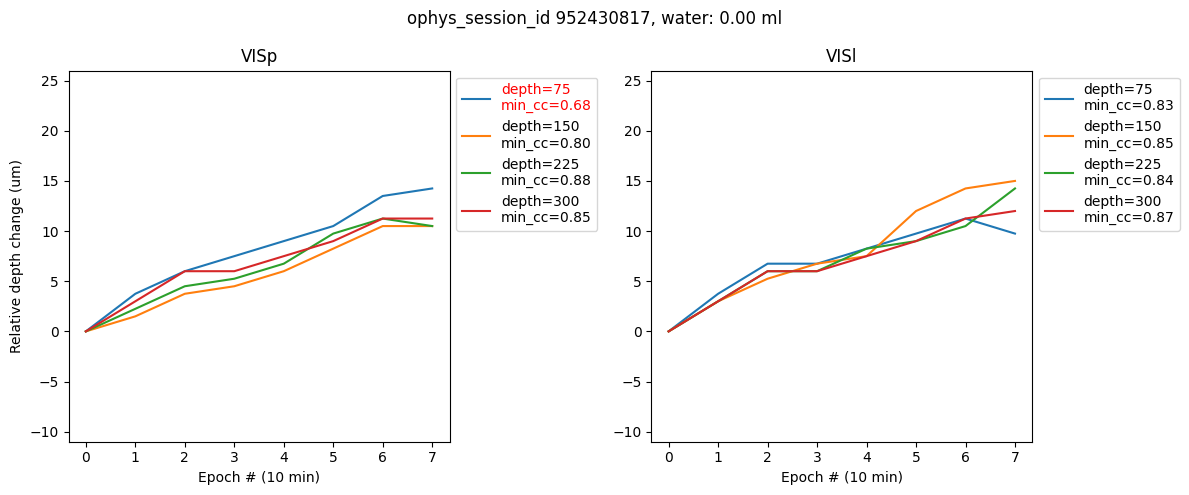

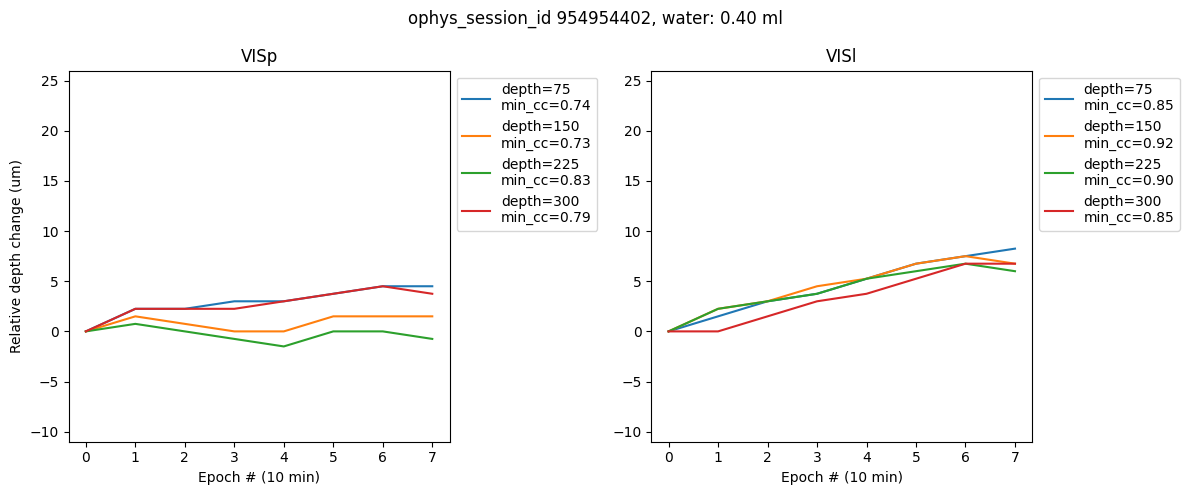

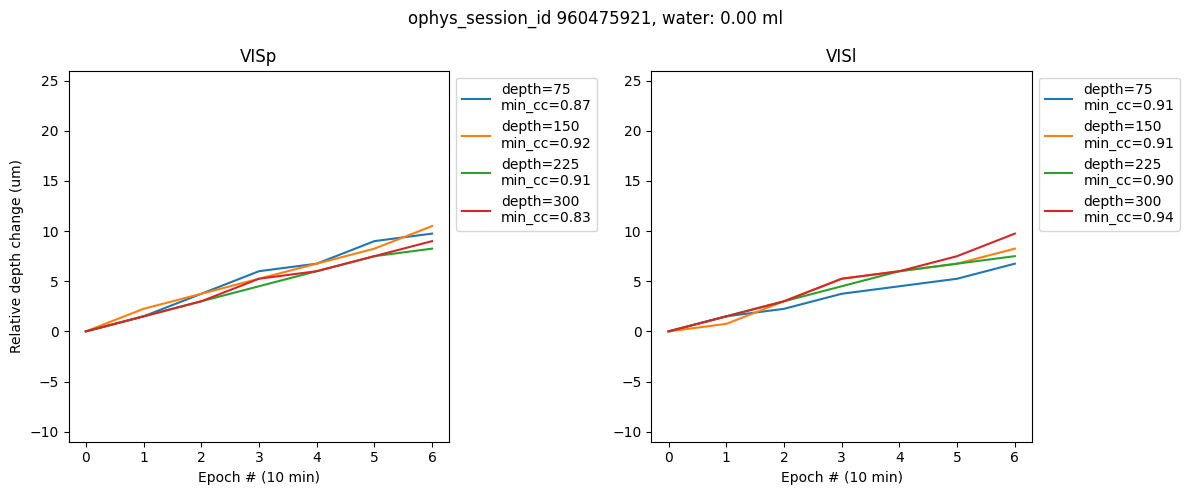

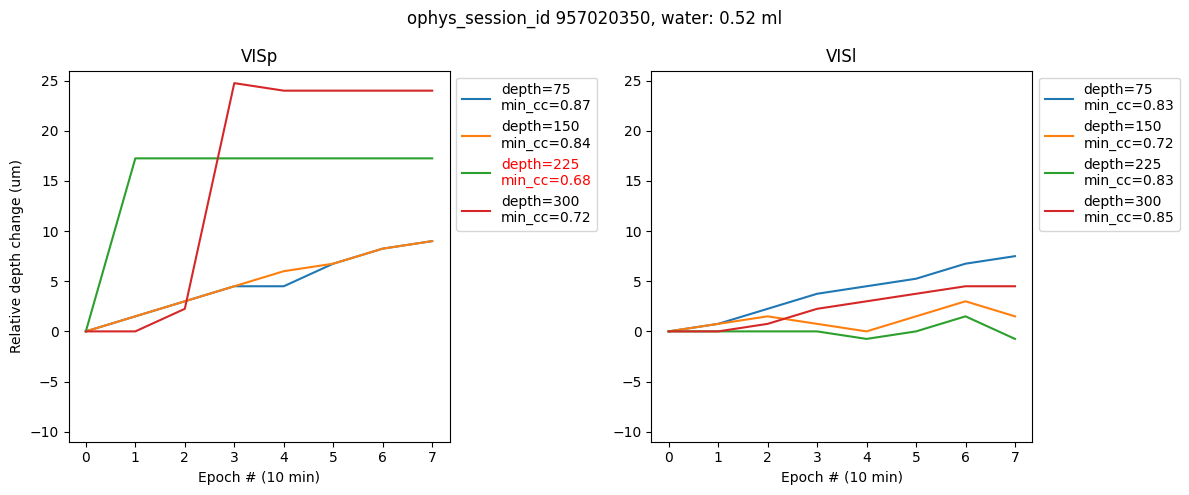

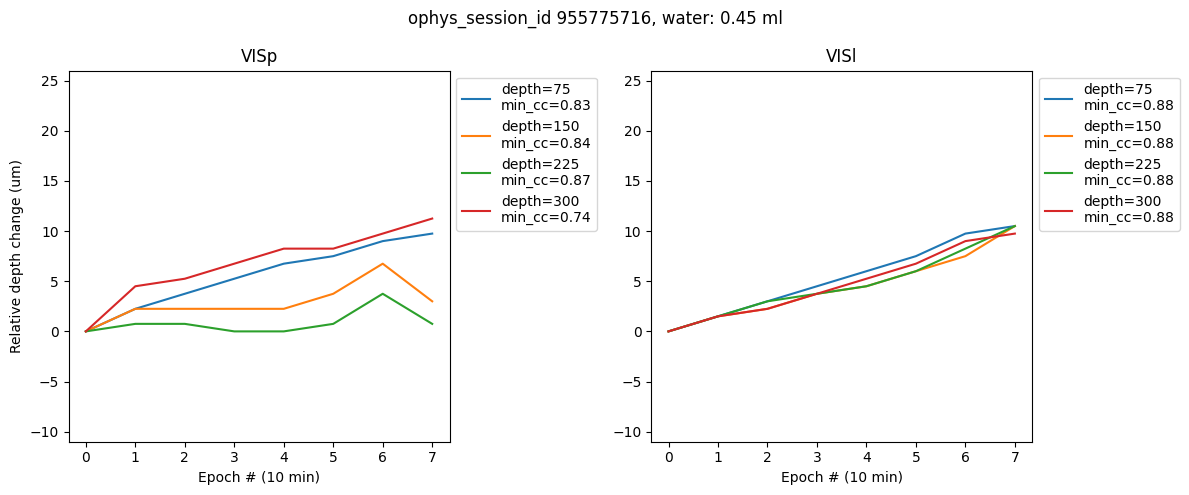

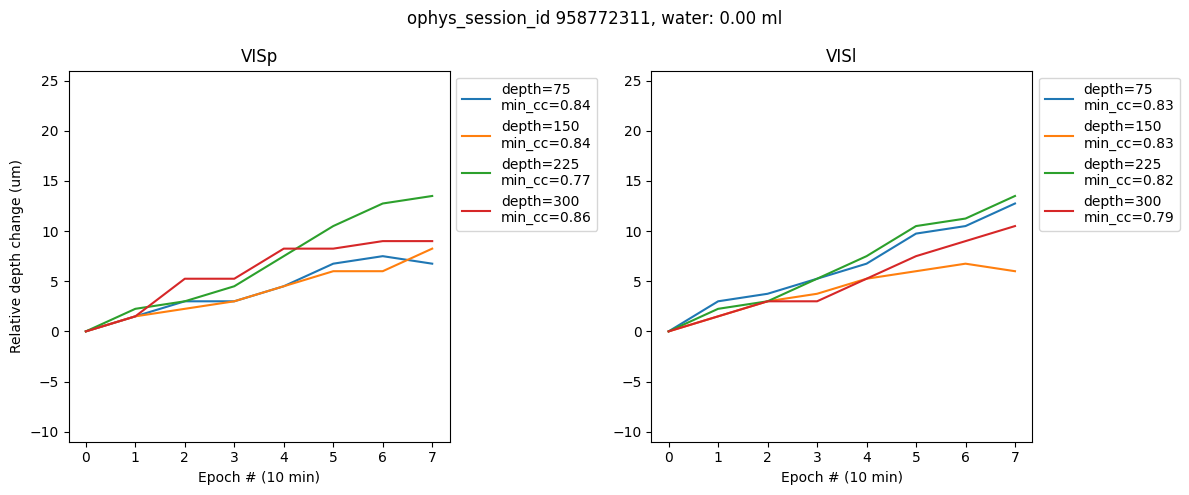

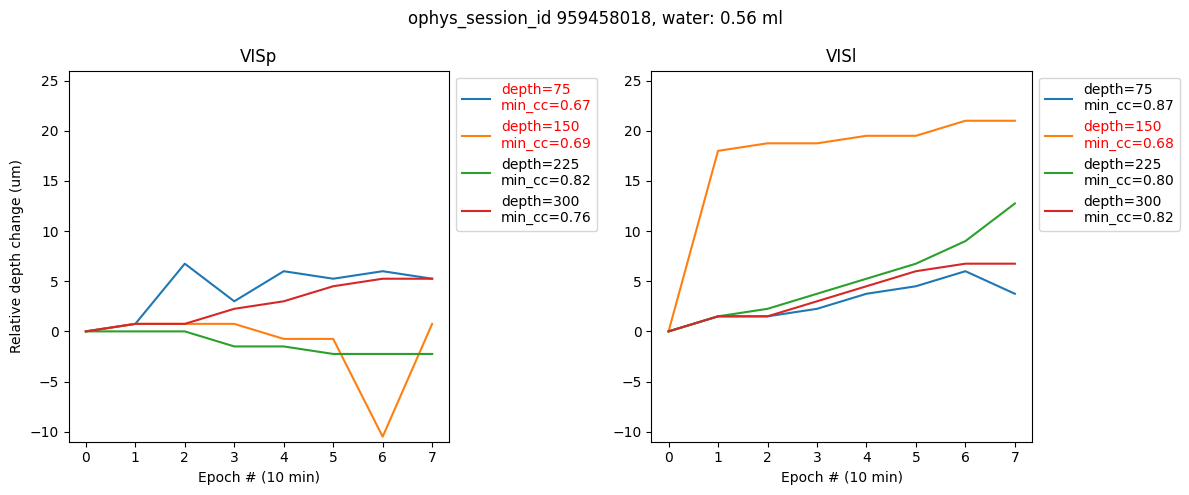

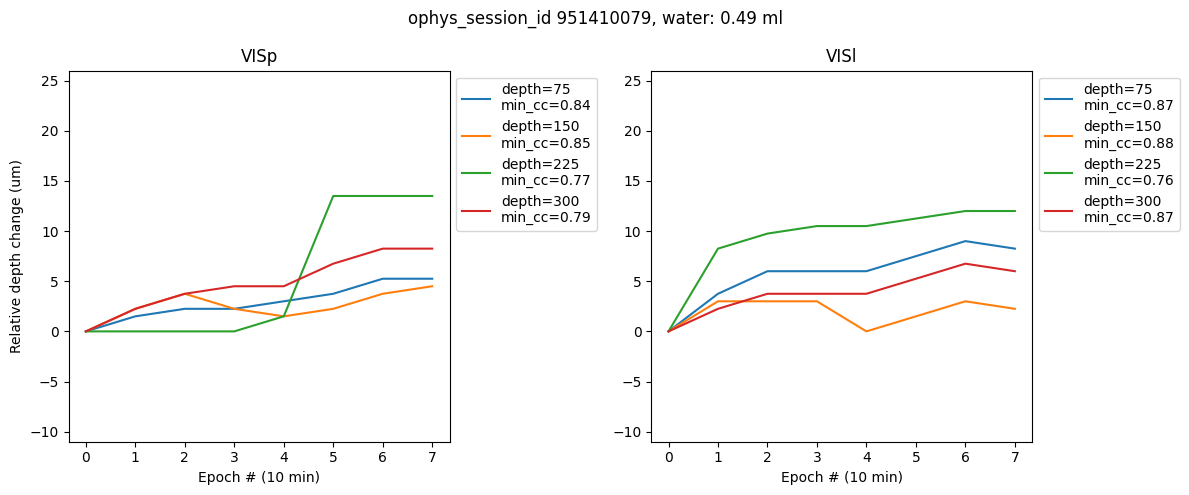

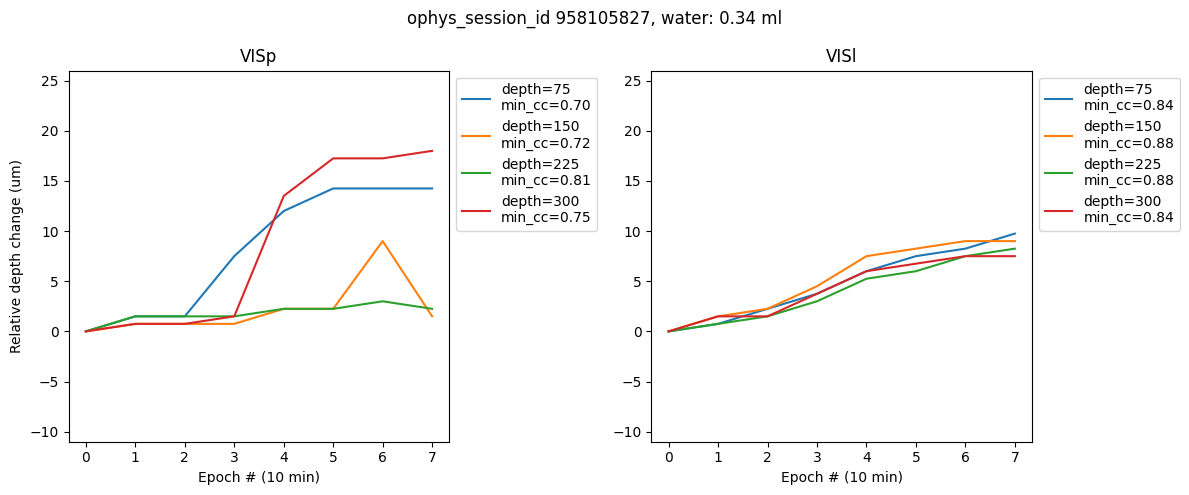

In [27]:
targeted_structures = ['VISp', 'VISl']
# mouse_id = sst_table[sst_table.water == sst_table.water.max()].mouse_id.values[0]
mouse_id = sst_table.mouse_id.unique()[0]
osids = sst_table[sst_table.mouse_id == mouse_id].ophys_session_id.values
oeid_all = []
cc_all = []
depth_all = []
water_all = []
for osid in osids:
    water_all.append(table.query('ophys_session_id == @osid').water.values[0])
    corrcoef, matched_plane_indices, oeids = get_zdrift_results(osid, zdrift_dir)
    relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]
    cc_all.append(corrcoef)
    oeid_all.append(oeids)
    depth_all.append(relative_depth_change)

depth_range = (round(np.min([np.min(d) for d in depth_all]))-1, round(np.max([np.max(d) for d in depth_all]))+1)

for osid_i in range(len(osids)):
    osid = osids[osid_i]
    oeid = oeid_all[osid_i]
    corrcoef = cc_all[osid_i]
    relative_depth_change = depth_all[osid_i]
    water = water_all[osid_i]
    depth = []
    region = []
    for oeid in oeids:
        depth.append(vbms_table.query('ophys_experiment_id == @oeid').imaging_depth.values[0])
        region.append(vbms_table.query('ophys_experiment_id == @oeid').targeted_structure.values[0])
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    for i in range(2):
        target = targeted_structures[i]
        temp_inds = np.where(np.array(region) == target)[0]
        temp_depths = np.array(depth)[temp_inds]
        temp_order = np.argsort(temp_depths)
        min_cc = [np.min(corrcoef[ti]) for ti in temp_inds]
        for oi in temp_order:
            ax[i].plot(relative_depth_change[temp_inds[oi]],
                       label=f'depth={temp_depths[oi]}\nmin_cc={min_cc[oi]:.2f}')
        ax[i].set_title(target)
        ax[i].set_ylim(depth_range[0], depth_range[1])
        legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1,1))
        
        for j, text in enumerate(legend.get_texts()):
            if min_cc[temp_order[j]] < 0.7:
                text.set_color('red')
        ax[i].set_xlabel('Epoch # (10 min)')
    ax[0].set_ylabel('Relative depth change (um)')
    fig.suptitle(f'ophys_session_id {osid}, water: {water:.2f} ml')
    fig.tight_layout()


## Water uptake distribution

Text(0, 0.5, 'Cumulative distribution')

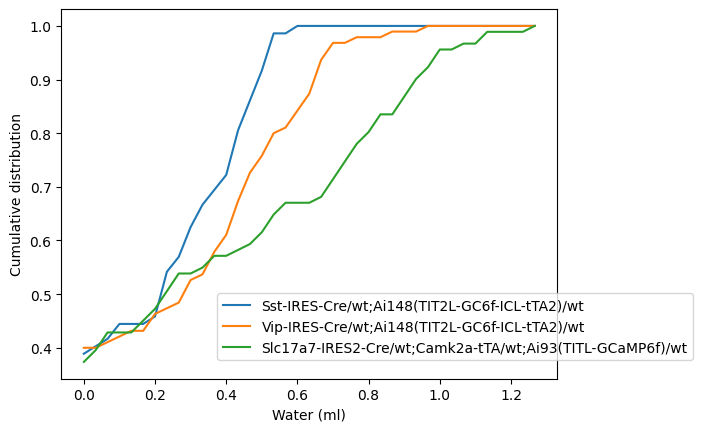

In [9]:
bins = np.linspace(0, 1.3, 40)
genotypes = table.full_genotype.unique()
fig, ax = plt.subplots()
for genotype in genotypes:
    temp_water = table.query("full_genotype == @genotype").water.values
    water_hist, _ = np.histogram(temp_water, bins=bins)
    water_cumhist = np.cumsum(water_hist) / np.sum(water_hist)
    ax.plot(bins[:-1], water_cumhist, label=genotype)
ax.legend(loc='upper left', bbox_to_anchor=(0.3,0.25))
ax.set_xlabel('Water (ml)')
ax.set_ylabel('Cumulative distribution')


In [15]:
# adding GAD2 neurons
cache = bpc.from_lims()
all_table = cache.get_ophys_experiment_table(passed_only=False)
lamf_table = all_table.query('project_code == "LearningmFISHTask1A"')
lamf_table = lamf_table[~(lamf_table.session_type.str.contains("TRAINING_0_"))]
last_run_time = datetime(2024, 2, 28, 0, 0, 0)
lamf_zdrift_run_table = lamf_table[lamf_table.apply(lambda x: pd.to_datetime(x.date_of_acquisition) < last_run_time, axis=1)].groupby(
    'ophys_session_id').apply(
    lambda x: len(x.targeted_structure.unique())<=2)

In [16]:
lamf_zdrift_run_table.head()

ophys_session_id
1153529245    False
1153776022    False
1154000392    False
1154245678    False
1154460714    False
dtype: bool

In [19]:
gad2_osids = lamf_zdrift_run_table[lamf_zdrift_run_table].index.values
gad2_water_recorded_osid = []
gad2_water_volume = []
for osid in gad2_osids:
    session = mongo.qc.metrics.find_one({'lims_id': int(osid)})
    if 'change_detection' in session.keys():
        try:
            if 'total_water' in session['change_detection'].keys():
                total_water = session['change_detection']['total_water']
                earned_water = session['change_detection']['earned_water']
            else:
                total_water = session['change_detection']['behavior_stats'][0]['total_water']
                earned_water = session['change_detection']['behavior_stats'][0]['earned_water']
            if 'OPHYS_6_' in lamf_table.query('ophys_session_id == @osid').session_type.unique()[0]:
                gad2_water_volume.append(total_water - earned_water)
            else:
                gad2_water_volume.append(total_water)
            gad2_water_recorded_osid.append(osid)
        except:
            pass
assert len(gad2_water_recorded_osid) == len(gad2_water_volume)

Text(0, 0.5, 'Cumulative distribution')

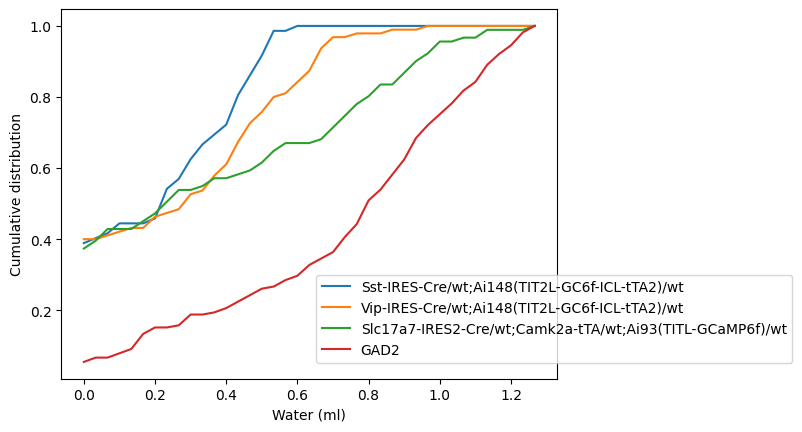

In [26]:
bins = np.linspace(0, 1.3, 40)
genotypes = table.full_genotype.unique()
fig, ax = plt.subplots()
for genotype in genotypes:
    temp_water = table.query("full_genotype == @genotype").water.values
    water_hist, _ = np.histogram(temp_water, bins=bins)
    water_cumhist = np.cumsum(water_hist) / np.sum(water_hist)
    ax.plot(bins[:-1], water_cumhist, label=genotype)
water_hist, _ = np.histogram(gad2_water_volume, bins=bins)
water_cumhist = np.cumsum(water_hist) / np.sum(water_hist)
ax.plot(bins[:-1], water_cumhist, label='GAD2')
ax.legend(loc='upper left', bbox_to_anchor=(0.5,0.3))
ax.set_xlabel('Water (ml)')
ax.set_ylabel('Cumulative distribution')

# Water vs z-drift spread

In [11]:
# Load tables
cache = bpc.from_lims()
exp_table = cache.get_ophys_experiment_table(passed_only=False)
vbms_table = exp_table.query('project_code == "VisualBehaviorMultiscope"')

zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
load_fn = zdrift_dir / 'multi_plane_zdrift_vb_multiscope_processed.csv'
table = pd.read_csv(load_fn)
table.set_index('ophys_session_id', drop=True, inplace=True)

In [21]:
# Takes 14 minutes
local_zstack_interval = 0.75
zdrift_spread = []
zdrift_spread_visp = []
zdrift_spread_visl = []
min_cc = []
min_cc_visp = []
min_cc_visl = []

zdrift_osid = []
error_osid = []
for osid in table.index.values:
    try:
        cc, matched_plane_indices, opids = get_zdrift_results_first_last(osid, zdrift_dir)
        cc = np.array(cc)
        zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
        
        zdrift_spread.append(zdrift_session.var())
        zdrift_osid.append(osid)

        visp_inds = []
        visl_inds = []
        for i in range(len(opids)):
            opid = opids[i]
            if vbms_table.loc[opid].targeted_structure == 'VISp':
                visp_inds.append(i)
            elif vbms_table.loc[opid].targeted_structure == 'VISl':
                visl_inds.append(i)
            else:
                raise ValueError(f'{osid} contains regions other than VISp and VISl')
        visp_inds = np.array(visp_inds)
        visl_inds = np.array(visl_inds)

        zdrift_spread_visp.append(zdrift_session[visp_inds].var())
        zdrift_spread_visl.append(zdrift_session[visl_inds].var())
        
        min_cc.append(np.min(cc))
        min_cc_visp.append(np.min(cc[visp_inds, :]))
        min_cc_visl.append(np.min(cc[visl_inds, :]))
    except:
        error_osid.append(osid)

assert len(zdrift_osid) == len(zdrift_spread) == len(zdrift_spread_visp) == len(min_cc_visl)

In [22]:
table['zdrift_spread'] = None
table['zdrift_spread_visp'] = None
table['zdrift_spread_visl'] = None
table['min_cc'] = None
table['min_cc_visp'] = None
table['min_cc_visl'] = None
for i in range(len(zdrift_osid)):
    osid = zdrift_osid[i]
    table.loc[osid, 'zdrift_spread'] = zdrift_spread[i]
    table.loc[osid, 'zdrift_spread_visp'] = zdrift_spread_visp[i]
    table.loc[osid, 'zdrift_spread_visl'] = zdrift_spread_visl[i]
    table.loc[osid, 'min_cc'] = min_cc[i]
    table.loc[osid, 'min_cc_visp'] = min_cc_visp[i]
    table.loc[osid, 'min_cc_visl'] = min_cc_visl[i]

<AxesSubplot:>

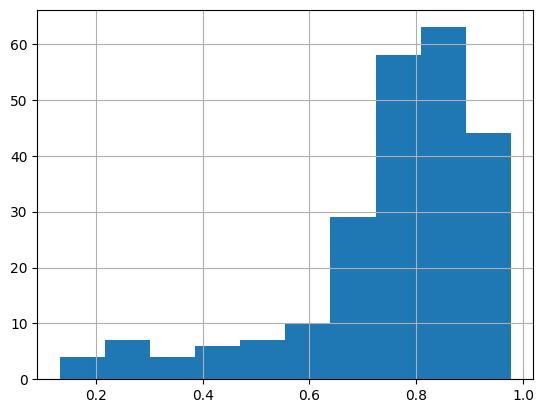

In [71]:
table.min_cc_visl.hist()

In [23]:
save_fn = 'multi_plane_zdrift_spread_vs_water_vb_multiscope.pkl'
table.to_pickle(zdrift_dir / save_fn)

### Loading spread vs water calculation

In [4]:
load_fn = 'multi_plane_zdrift_spread_vs_water_vb_multiscope.pkl'
table = pd.read_pickle(zdrift_dir / load_fn)

In [5]:
table.full_genotype.unique()

array(['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'],
      dtype=object)

<AxesSubplot:xlabel='water', ylabel='zdrift_spread'>

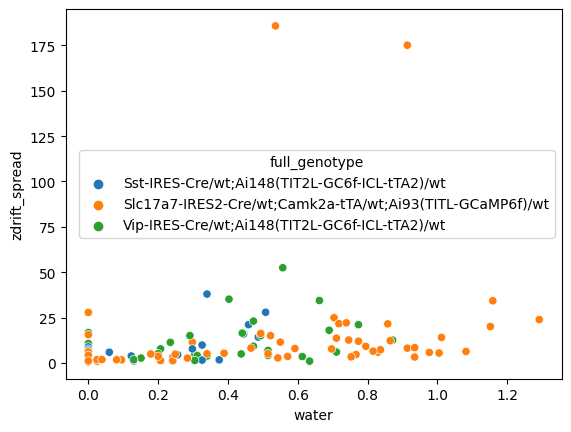

In [24]:

fig, ax = plt.subplots()
sns.scatterplot(table.query('min_cc >= 0.7'), x='water', y='zdrift_spread', hue='full_genotype')

<AxesSubplot:xlabel='water', ylabel='zdrift_spread_visp'>

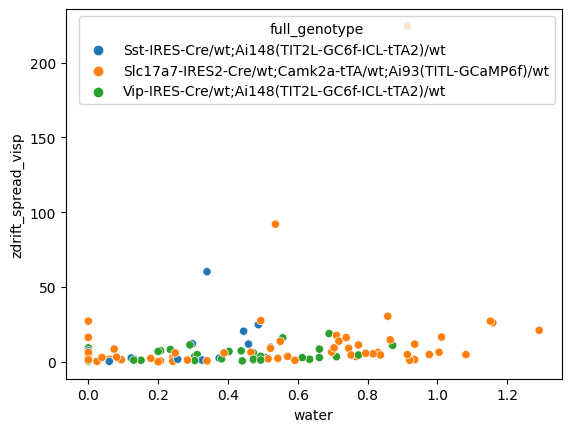

In [8]:
fig, ax = plt.subplots()
sns.scatterplot(table.query('min_cc_visp >= 0.7'), x='water', y='zdrift_spread_visp', hue='full_genotype')

<AxesSubplot:xlabel='water', ylabel='zdrift_spread_visl'>

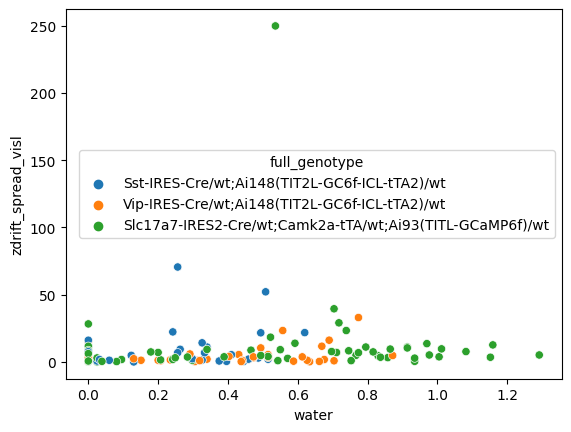

In [29]:
fig, ax = plt.subplots()
sns.scatterplot(table.query('min_cc_visl >= 0.7'), x='water', y='zdrift_spread_visl', hue='full_genotype')

In [30]:
table.query('water < 0.4 and zdrift_spread_visl > 50 and min_cc_visl >= 0.7')

,mouse_id,full_genotype,session_type,water,processed,zdrift_spread,zdrift_spread_visp,zdrift_spread_visl,min_cc,min_cc_visp,min_cc_visl
ophys_session_id,,,,,,,,,,,
976167513,482853,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,OPHYS_1_images_A,0.256,True,38.170898,0.667969,70.59375,0.685744,0.685744,0.801965


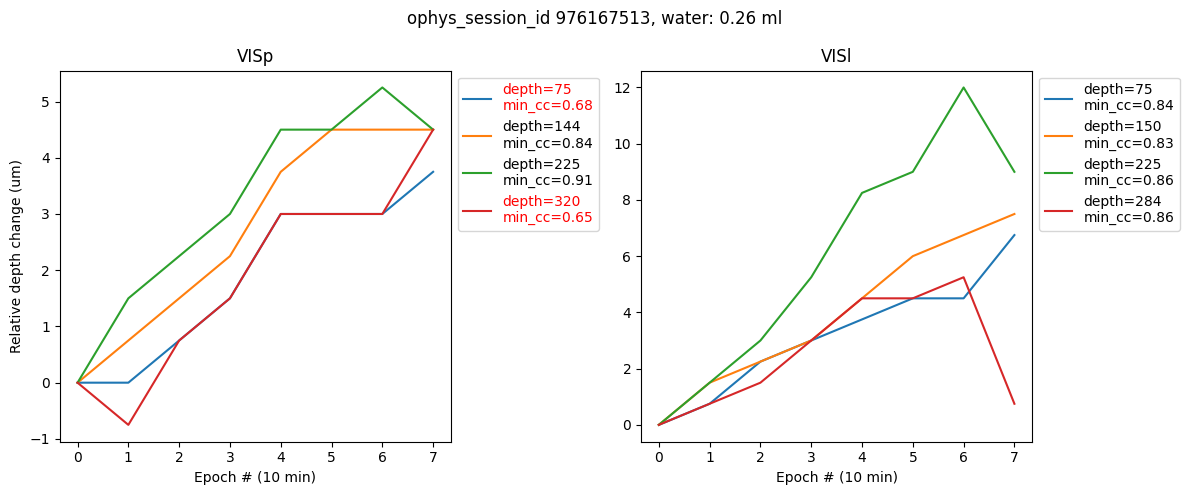

In [34]:
targeted_structures = ['VISp', 'VISl']

osid = 976167513
corrcoef, matched_plane_indices, opids = get_zdrift_results(osid, zdrift_dir)
water = table.loc[osid].water
relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]
depth = []
region = []
for opid in opids:
    depth.append(vbms_table.query('ophys_experiment_id == @opid').imaging_depth.values[0])
    region.append(vbms_table.query('ophys_experiment_id == @opid').targeted_structure.values[0])


fig, ax = plt.subplots(1,2, figsize=(12,5))
for i in range(2):
    target = targeted_structures[i]
    temp_inds = np.where(np.array(region) == target)[0]
    temp_depths = np.array(depth)[temp_inds]
    temp_order = np.argsort(temp_depths)
    min_cc = [np.min(corrcoef[ti]) for ti in temp_inds]
    for oi in temp_order:
        ax[i].plot(relative_depth_change[temp_inds[oi]],
                    label=f'depth={temp_depths[oi]}\nmin_cc={min_cc[oi]:.2f}')
    ax[i].set_title(target)
    # ax[i].set_ylim(depth_range[0], depth_range[1])
    legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1,1))
    
    for j, text in enumerate(legend.get_texts()):
        if min_cc[temp_order[j]] < 0.7:
            text.set_color('red')
    ax[i].set_xlabel('Epoch # (10 min)')
ax[0].set_ylabel('Relative depth change (um)')
fig.suptitle(f'ophys_session_id {osid}, water: {water:.2f} ml')
fig.tight_layout()

In [39]:
cc_fl, matched_plane_indices_fl, opids_fl = get_zdrift_results_first_last(osid, zdrift_dir)
zdrift_session_fl = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices_fl])
visp_inds = []
visl_inds = []
for i in range(len(opids_fl)):
    opid = opids_fl[i]
    if vbms_table.loc[opid].targeted_structure == 'VISp':
        visp_inds.append(i)
    elif vbms_table.loc[opid].targeted_structure == 'VISl':
        visl_inds.append(i)
    else:
        raise ValueError(f'{osid} contains regions other than VISp and VISl')
visp_inds = np.array(visp_inds)
visl_inds = np.array(visl_inds)

zdrift_spread_visp_fl = zdrift_session_fl[visp_inds].var()
zdrift_spread_visl_fl = zdrift_session_fl[visl_inds].var()

In [41]:
visl_inds

array([0, 1, 2, 3])

In [37]:
zdrift_session_fl

array([21.  ,  9.  , -2.25,  5.25,  6.  ,  5.25,  5.25,  3.75])

In [40]:
relative_depth_change

[[0.0, 1.5, 3.0, 5.25, 8.25, 9.0, 12.0, 9.0],
 [0.0, 1.5, 2.25, 3.0, 4.5, 6.0, 6.75, 7.5],
 [0.0, 0.75, 1.5, 3.0, 4.5, 4.5, 5.25, 0.75],
 [0.0, 0.75, 2.25, 3.0, 3.75, 4.5, 4.5, 6.75],
 [0.0, 1.5, 2.25, 3.0, 4.5, 4.5, 5.25, 4.5],
 [0.0, 0.75, 1.5, 2.25, 3.75, 4.5, 4.5, 4.5],
 [0.0, -0.75, 0.75, 1.5, 3.0, 3.0, 3.0, 4.5],
 [0.0, 0.0, 0.75, 1.5, 3.0, 3.0, 3.0, 3.75]]

# Huge difference between first-last calculation and episodic mean FOV
- From one example
- Look at them across sessions

In [ ]:
corrcoef, matched_plane_indices, opids = get_zdrift_results(osid, zdrift_dir)
water = table.loc[osid].water
relative_depth_change = [[(mpi[i] - mpi[0])*0.75 for i in range(len(mpi))] for mpi in matched_plane_indices]